In [6]:
# CELL 1: Load CSV and Basic Setup
import pandas as pd
from pathlib import Path
import nibabel as nib
import numpy as np
from nilearn import plotting, image
import matplotlib.pyplot as plt

# Load subject info from CSV
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
df = pd.read_csv(CSV_FILE)

BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Session start mapping (for special cases)
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

# Cope mapping: Key -> (Cope Number, Multiplier)
# Multiplier 1  = Use contrast as is (e.g., Face > Scramble)
# Multiplier -1 = Invert contrast (e.g., Face > Word becomes Word > Face)

COPE_MAP = {
    'face':   (10, 1),   # Face > Scramble
    'word':   (13, -1),  # Face > Word (INVERTED to create Word > Face)
    'object': (3,  1),   # Object > Scramble
    'house':  (11, 1)    # House > Scramble
}

# Parcels are touchy. 
CATEGORY_PARCELS = {
    'face': ['fusiform'],
    'word': ['fusiform', 'inferiortemporal'], # needed to add IT to capture VWFA
    'object': ['lateraloccipital'],
    'house': ['parahippocampal', 'lingual', 'isthmuscingulate']
}

print("✓ CSV loaded and configuration set")

✓ CSV loaded and configuration set


In [7]:
# CELL 2: Streamlined Subject Loading and Configuration
def load_subjects_by_group(group_filter=None, patient_only=True):
    """Streamlined subject loading with proper configuration"""
    
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
            
        # Get available sessions
        sessions = []
        for ses_dir in subj_dir.glob('ses-*'):
            if ses_dir.is_dir():
                sessions.append(ses_dir.name.replace('ses-', ''))
        
        if not sessions:
            continue
            
        sessions = sorted(sessions, key=lambda x: int(x))
        start_session = SESSION_START.get(subject_id, 1)
        available_sessions = [s for s in sessions if int(s) >= start_session]
        
        if not available_sessions:
            continue
        
        # Proper hemisphere mapping
        if row['patient'] == 1:  # Patients
            hemisphere_full = row.get('intact_hemi', 'left')
            hemisphere = 'l' if hemisphere_full == 'left' else 'r'
        else:  # Controls 
            hemisphere = 'r'  # Default for controls (we'll add bilateral later)
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': available_sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'age_1': row['age_1'] if pd.notna(row['age_1']) else None,
            'surgery_side': row.get('SurgerySide', None) if row['patient'] == 1 else None
        }
    
    return subjects

# Load subjects systematically
ALL_PATIENTS = load_subjects_by_group(group_filter=None, patient_only=True)
OTC_PATIENTS = load_subjects_by_group(group_filter='OTC', patient_only=True)
NON_OTC_PATIENTS = load_subjects_by_group(group_filter='nonOTC', patient_only=True)
ALL_CONTROLS = load_subjects_by_group(group_filter=None, patient_only=False)

# Start with original subjects only
ANALYSIS_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS}

print("STREAMLINED SUBJECT LOADING COMPLETE")
print("="*50)
print(f"Patients loaded: {len(ALL_PATIENTS)}")
print(f"  - OTC: {len(OTC_PATIENTS)}")
print(f"  - nonOTC: {len(NON_OTC_PATIENTS)}")
print(f"Controls loaded: {len(ALL_CONTROLS)}")
print(f"Total analysis subjects: {len(ANALYSIS_SUBJECTS)}")

print(f"\nCORRECT CATEGORY_PARCELS:")
for category, parcels in CATEGORY_PARCELS.items():
    print(f"  {category:6s}: {parcels}")

print(f"\nSample subjects:")
for subj_id, info in list(ANALYSIS_SUBJECTS.items())[:3]:
    print(f"  {info['code']}: {info['group']} {info['patient_status']}, hemi='{info['hemi']}'")

STREAMLINED SUBJECT LOADING COMPLETE
Patients loaded: 15
  - OTC: 6
  - nonOTC: 9
Controls loaded: 9
Total analysis subjects: 24

CORRECT CATEGORY_PARCELS:
  face  : ['fusiform']
  word  : ['fusiform', 'inferiortemporal']
  object: ['lateraloccipital']
  house : ['parahippocampal', 'lingual', 'isthmuscingulate']

Sample subjects:
  OTC004: OTC patient, hemi='l'
  nonOTC007: nonOTC patient, hemi='r'
  OTC008: OTC patient, hemi='l'


In [8]:
# CELL 3: Functional ROI Extraction (FIXED IMPORTS)
from scipy.ndimage import label, center_of_mass 
import numpy as np
import nibabel as nib

def extract_functional_rois_bilateral(subject_id, threshold_z=2.3, min_cluster_size=30):
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, cope_params in COPE_MAP.items():
            # Unpack Tuple
            cope_num, multiplier = cope_params if isinstance(cope_params, tuple) else (cope_params, 1)
            
            # Load Search Mask
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists(): continue
            
            try:
                search_mask = nib.load(mask_file).get_fdata() > 0
                affine = nib.load(mask_file).affine
            except: continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists(): continue
                
                try:
                    # Load & Invert
                    zstat = nib.load(cope_file).get_fdata() * multiplier
                    
                    # Threshold
                    suprathresh = (zstat > threshold_z) & search_mask
                    
                    # Cluster & Filter
                    labeled, n_clusters = label(suprathresh) # <--- This is where it failed
                    if n_clusters == 0: continue
                    
                    best_idx = -1
                    max_peak = -999
                    
                    for i in range(1, n_clusters + 1):
                        cluster_mask = (labeled == i)
                        if np.sum(cluster_mask) >= min_cluster_size:
                            peak_val = np.max(zstat[cluster_mask])
                            if peak_val > max_peak:
                                max_peak = peak_val
                                best_idx = i
                    
                    if best_idx == -1: continue 
                    
                    # Save Result
                    roi_mask = (labeled == best_idx)
                    peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': zstat[peak_idx],
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'roi_mask': roi_mask
                    }
                except Exception as e: print(f"Err {subject_id} {category}: {e}")

    return all_results

# EXECUTE
print("Re-running extraction...")
golarai_functional_final = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_functional_rois_bilateral(sub, min_cluster_size=30)
    if res: golarai_functional_final[sub] = res
print(f"✓ Extraction Complete: {len(golarai_functional_final)} subjects.")

Re-running extraction...
✓ Extraction Complete: 23 subjects.


In [9]:
# CELL 4: Verify Selectivity (Tuple Corrected)
def verify_roi_selectivity(functional_results, subjects, sample_ids=['OTC004', 'control025']):
    print("\nROI SELECTIVITY CHECK")
    print("="*40)
    
    for pid in sample_ids:
        # Find full ID
        sid = next((k for k,v in subjects.items() if v['code'] == pid), None)
        if not sid or sid not in functional_results: continue
        
        print(f"\n>> {pid}:")
        res = functional_results[sid]
        first_ses = subjects[sid]['sessions'][0]
        
        for roi_name in sorted(res.keys()):
            if first_ses not in res[roi_name]: continue
            roi_mask = res[roi_name][first_ses]['roi_mask']
            target_cat = roi_name.split('_')[1]
            
            scores = {}
            feat_dir = BASE_DIR / sid / f'ses-{first_ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            
            for cat, (cope, mult) in COPE_MAP.items():
                f = feat_dir / f'cope{cope}.feat' / 'stats' / 'zstat1.nii.gz'
                if f.exists():
                    d = nib.load(f).get_fdata() * mult
                    scores[cat] = np.mean(d[roi_mask])
            
            top = max(scores, key=scores.get)
            mark = "✓" if top == target_cat else "✗"
            print(f"  {roi_name:10s}: {mark} Top={top} (Target: {scores.get(target_cat,0):.2f})")
            
verify_roi_selectivity(golarai_functional_final, ANALYSIS_SUBJECTS)


ROI SELECTIVITY CHECK

>> OTC004:
  l_face    : ✓ Top=face (Target: 2.67)
  l_house   : ✓ Top=house (Target: 3.08)
  l_object  : ✓ Top=object (Target: 3.53)
  l_word    : ✓ Top=word (Target: 2.81)

>> control025:
  l_face    : ✓ Top=face (Target: 6.56)
  l_house   : ✓ Top=house (Target: 4.29)
  l_object  : ✓ Top=object (Target: 5.16)
  l_word    : ✓ Top=word (Target: 4.15)
  r_face    : ✓ Top=face (Target: 5.65)
  r_house   : ✓ Top=house (Target: 4.22)
  r_object  : ✓ Top=object (Target: 5.00)
  r_word    : ✓ Top=word (Target: 3.28)


In [10]:
# CELL 5: Hybrid Stability (with Hemisphere tracking)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from pathlib import Path

def compute_hybrid_stability(functional_results, subjects, min_voxels=30):
    EXTRACTION_MAP = {'face': 10, 'house': 11, 'object': 3, 'word': 12}
    CATEGORY_TYPES = {
        'face': 'Asymmetric', 'word': 'Asymmetric',
        'house': 'Bilateral', 'object': 'Bilateral'
    }
    
    data = []
    
    for sid, res in functional_results.items():
        if sid not in subjects: continue
        info = subjects[sid]
        
        sessions = sorted(list({s for r in res.values() for s in r.keys()}))
        if len(sessions) < 2: continue
        first_ses = sessions[0]
        
        for roi_name, roi_data in res.items():
            hemi = roi_name.split('_')[0]  # Extract 'l' or 'r'
            cat = roi_name.split('_')[1]
            if first_ses not in roi_data: continue
            
            mask = roi_data[first_ses]['roi_mask']
            if np.sum(mask) < min_voxels: continue
            
            patterns = {}
            valid_extraction = True
            
            for ses in sessions:
                f = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z = f / f'cope{EXTRACTION_MAP[cat]}.feat' / 'stats' / ('zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_ses}.nii.gz')
                
                if z.exists():
                    try: patterns[ses] = nib.load(z).get_fdata()[mask]
                    except: valid_extraction = False
                else: valid_extraction = False
            
            if valid_extraction and sessions[-1] in patterns:
                if np.std(patterns[first_ses]) > 0 and np.std(patterns[sessions[-1]]) > 0:
                    corr = np.corrcoef(patterns[first_ses], patterns[sessions[-1]])[0,1]
                    
                    data.append({
                        'Subject': info['code'],
                        'Group': info['group'],
                        'Hemisphere': hemi.upper(),  # ADD THIS
                        'Category': cat.capitalize(),
                        'Type': CATEGORY_TYPES.get(cat, 'Other'), 
                        'Stability (r)': corr
                    })
                
    return pd.DataFrame(data)

df_hybrid = compute_hybrid_stability(golarai_functional_final, ANALYSIS_SUBJECTS)
print(f"✓ Hybrid stability: {len(df_hybrid)} observations")
print(df_hybrid.groupby(['Group', 'Hemisphere']).size())

✓ Hybrid stability: 126 observations
Group    Hemisphere
OTC      L              8
         R             11
control  L             36
         R             35
nonOTC   L             20
         R             16
dtype: int64


In [11]:
# CELL 6: Spatial Drift Analysis (with Hemisphere tracking)
import numpy as np
import pandas as pd

def analyze_drift(functional_results, subjects, min_voxels=30):
    """Calculate spatial drift between first and last sessions"""
    data = []
    
    CATEGORY_TYPES = {
        'face': 'Asymmetric', 'word': 'Asymmetric',
        'house': 'Bilateral', 'object': 'Bilateral'
    }
    
    for sid, res in functional_results.items():
        if sid not in subjects: continue
        info = subjects[sid]
        
        sessions = sorted(list({s for r in res.values() for s in r.keys()}))
        if len(sessions) < 2: continue
        
        first_ses = sessions[0]
        last_ses = sessions[-1]
        
        for roi_name, roi_data in res.items():
            hemi = roi_name.split('_')[0]  # Extract 'l' or 'r'
            cat = roi_name.split('_')[1]
            
            if first_ses not in roi_data or last_ses not in roi_data: continue
            
            # Check voxel counts
            if roi_data[first_ses]['n_voxels'] < min_voxels: continue
            if roi_data[last_ses]['n_voxels'] < min_voxels: continue
            
            # Calculate Euclidean distance between centroids
            c1 = roi_data[first_ses]['centroid']
            c2 = roi_data[last_ses]['centroid']
            drift = np.sqrt(np.sum((c2 - c1)**2))
            
            data.append({
                'Subject': info['code'],
                'Group': info['group'],
                'Hemisphere': hemi.upper(),  # ADD THIS
                'Category': cat.capitalize(),
                'Type': CATEGORY_TYPES.get(cat, 'Other'),
                'Drift (mm)': drift
            })
    
    return pd.DataFrame(data)

df_drift = analyze_drift(golarai_functional_final, ANALYSIS_SUBJECTS, min_voxels=50)
print(f"✓ Spatial drift: {len(df_drift)} observations")
print(df_drift.groupby(['Group', 'Hemisphere']).size())

✓ Spatial drift: 122 observations
Group    Hemisphere
OTC      L              7
         R             10
control  L             36
         R             33
nonOTC   L             20
         R             16
dtype: int64


In [12]:
# CELL 7: RDM Stability Analysis (with Hemisphere tracking)
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.stats import pearsonr

def analyze_rdm(functional_results, subjects, min_voxels=30):
    """Calculate RDM stability between first and last sessions"""
    
    EXTRACTION_MAP = {'face': 10, 'house': 11, 'object': 3, 'word': 12}
    CATEGORY_TYPES = {
        'face': 'Asymmetric', 'word': 'Asymmetric',
        'house': 'Bilateral', 'object': 'Bilateral'
    }
    
    data = []
    
    for sid, res in functional_results.items():
        if sid not in subjects: continue
        info = subjects[sid]
        
        sessions = sorted(list({s for r in res.values() for s in r.keys()}))
        if len(sessions) < 2: continue
        
        first_ses = sessions[0]
        last_ses = sessions[-1]
        
        for roi_name, roi_data in res.items():
            hemi = roi_name.split('_')[0]  # Extract 'l' or 'r'
            cat = roi_name.split('_')[1]
            
            if first_ses not in roi_data or last_ses not in roi_data: continue
            
            # Check voxel threshold
            if roi_data[first_ses]['n_voxels'] < min_voxels: continue
            if roi_data[last_ses]['n_voxels'] < min_voxels: continue
            
            # Extract RDMs for both sessions
            rdms = {}
            for ses in [first_ses, last_ses]:
                mask = roi_data[ses]['roi_mask']
                
                # Extract all 4 categories
                patterns = []
                valid = True
                
                for c in ['face', 'house', 'object', 'word']:
                    feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                    z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_ses}.nii.gz'
                    z_file = feat_dir / f'cope{EXTRACTION_MAP[c]}.feat' / 'stats' / z_name
                    
                    if z_file.exists():
                        try:
                            z_data = nib.load(z_file).get_fdata()[mask]
                            patterns.append(z_data)
                        except:
                            valid = False
                            break
                    else:
                        valid = False
                        break
                
                if not valid or len(patterns) != 4: continue
                
                # Compute RDM (correlation matrix)
                try:
                    corr_matrix = np.corrcoef(patterns)
                    rdm = 1 - corr_matrix
                    rdms[ses] = rdm
                except:
                    continue
            
            # Calculate RDM stability
            if len(rdms) == 2:
                rdm1 = rdms[first_ses]
                rdm2 = rdms[last_ses]
                
                # Flatten upper triangle
                triu_idx = np.triu_indices(4, k=1)
                rdm1_flat = rdm1[triu_idx]
                rdm2_flat = rdm2[triu_idx]
                
                if len(rdm1_flat) > 0 and len(rdm2_flat) > 0:
                    r, _ = pearsonr(rdm1_flat, rdm2_flat)
                    
                    data.append({
                        'Subject': info['code'],
                        'Group': info['group'],
                        'Hemisphere': hemi.upper(),  # ADD THIS
                        'Category': cat.capitalize(),
                        'Type': CATEGORY_TYPES.get(cat, 'Other'),
                        'RDM Stability (r)': r
                    })
    
    return pd.DataFrame(data)

print("Calculating RDM Stability (Geometry Preservation)...")
df_rdm = analyze_rdm(golarai_functional_final, ANALYSIS_SUBJECTS, min_voxels=50)
print(f"✓ RDM stability: {len(df_rdm)} observations")
print(df_rdm.groupby(['Group', 'Hemisphere']).size())

Calculating RDM Stability (Geometry Preservation)...
✓ RDM stability: 122 observations
Group    Hemisphere
OTC      L              7
         R             10
control  L             36
         R             33
nonOTC   L             20
         R             16
dtype: int64


In [13]:
# CELL 8: Print Full Data Tables and export to csv
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

print("\n" + "="*80)
print("DATA TABLE 1: HYBRID STABILITY (Local Persistence)")
print("="*80)
if 'df_hybrid' in locals():
    print(df_hybrid.sort_values(by=['Group', 'Category', 'Subject']).to_string(index=False))

print("\n" + "="*80)
print("DATA TABLE 2: DRIFT ANALYSIS (Physical Movement)")
print("="*80)
if 'df_drift' in locals():
    print(df_drift.sort_values(by=['Group', 'Category', 'Subject']).to_string(index=False))

print("\n" + "="*80)
print("DATA TABLE 3: RDM STABILITY (Geometry)")
print("="*80)
if 'df_rdm' in locals():
    print(df_rdm.sort_values(by=['Group', 'Type', 'Subject']).to_string(index=False))


DATA TABLE 1: HYBRID STABILITY (Local Persistence)
   Subject   Group Hemisphere Category       Type  Stability (r)
    OTC004     OTC          L     Face Asymmetric       0.020357
    OTC008     OTC          L     Face Asymmetric       0.561324
    OTC010     OTC          R     Face Asymmetric       0.279279
    OTC017     OTC          R     Face Asymmetric       0.478746
    OTC021     OTC          R     Face Asymmetric       0.870352
    OTC004     OTC          L    House  Bilateral       0.226048
    OTC008     OTC          L    House  Bilateral       0.461196
    OTC010     OTC          R    House  Bilateral       0.214132
    OTC017     OTC          R    House  Bilateral       0.692992
    OTC021     OTC          R    House  Bilateral       0.417473
    OTC004     OTC          L   Object  Bilateral       0.379124
    OTC008     OTC          L   Object  Bilateral       0.248260
    OTC010     OTC          R   Object  Bilateral       0.526795
    OTC017     OTC          R   Object

COMPREHENSIVE RESULTS: ALL MEASURES

LIU_DISTINCTIVENESS
--------------------------------------------------
                        mean    sem  n
Group   Category_Type                 
OTC     Bilateral      0.368  0.053  5
        Unilateral     0.152  0.023  5
control Bilateral      0.259  0.026  9
        Unilateral     0.149  0.022  9
nonOTC  Bilateral      0.140  0.030  9
        Unilateral     0.131  0.027  9
  OTC Bil vs Uni: t=3.72, p=0.006

SPATIAL_DRIFT_MM
--------------------------------------------------
                         mean    sem  n
Group   Category_Type                  
OTC     Bilateral       6.014  1.292  5
        Unilateral     10.091  3.712  5
control Bilateral       5.314  1.038  9
        Unilateral      8.344  2.091  9
nonOTC  Bilateral       3.592  0.499  9
        Unilateral      6.202  0.883  9
  OTC Bil vs Uni: t=-1.04, p=0.330

HYBRID_STABILITY
--------------------------------------------------
                        mean    sem  n
Group   Catego

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Liu Distinctiveness ~ Group × Category + Age + Scan_Gap
                Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Liu_Distinctiveness
No. Observations:   46       Method:              REML               
No. Groups:         23       Scale:               0.0055             
Min. group size:    2        Log-Likelihood:      30.3926            
Max. group size:    2        Converged:           Yes                
Mean group size:    2.0                                              
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.100    0.087  1.151 0.250 -0.070  0.271
Group[T.control]            0.001    0.047  0.023 0.982 -0.092  0.094
Group[T.nonOTC]            -0.026    0.050 -0.527 0.598 -0.125  0.072
Bilateral                   0.216    0.047  4.609 

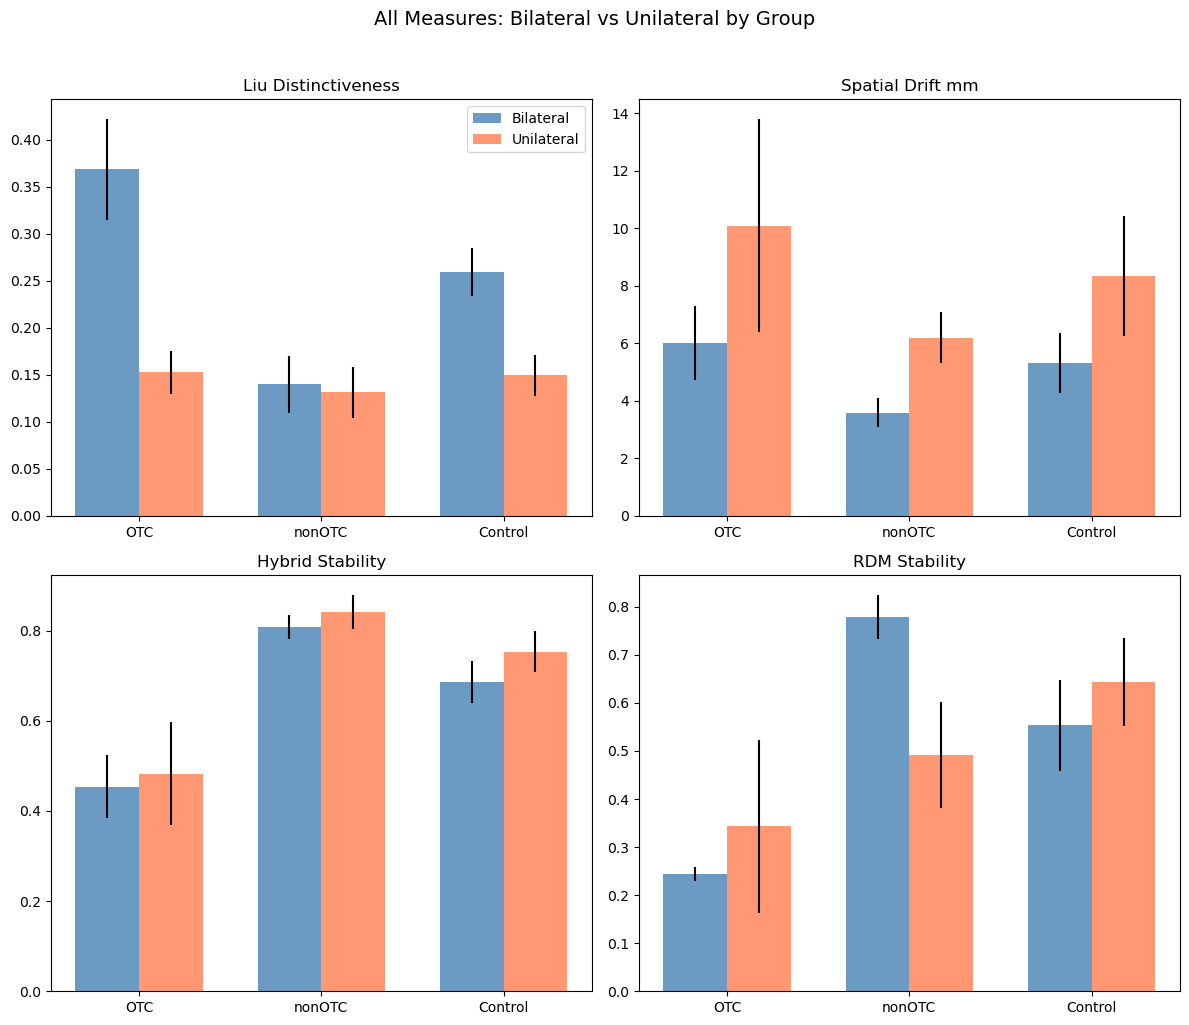


✓ Analysis complete! Files saved:
  - marlene_complete_summary.csv
  - marlene_all_measures.png


In [ ]:
# Brief Stats
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/user_data/csimmon2/git_repos/long_pt/B_analyses/results.csv')

# Clean data - one row per subject-category
df_clean = df.groupby(['Subject', 'Group', 'Intact_Hemisphere', 'Category_Type']).agg({
    'Liu_Distinctiveness': 'mean',
    'Spatial_Drift_mm': 'mean',
    'Hybrid_Stability': 'mean',
    'RDM_Stability': 'mean',
    'age_1': 'first',
    'scan_gap_years': 'first'
}).reset_index()

# Remove NaN values
df_clean = df_clean.dropna(subset=['Liu_Distinctiveness'])

print("="*70)
print("COMPREHENSIVE RESULTS: ALL MEASURES")
print("="*70)

# All measures summary
measures = ['Liu_Distinctiveness', 'Spatial_Drift_mm', 'Hybrid_Stability', 'RDM_Stability']

for measure in measures:
    print(f"\n{measure.upper()}")
    print("-"*50)
    
    summary = df_clean.groupby(['Group', 'Category_Type'])[measure].agg([
        ('mean', lambda x: x.mean()),
        ('sem', lambda x: x.sem()),
        ('n', 'count')
    ]).round(3)
    
    print(summary)
    
    # Test OTC bilateral vs unilateral
    otc_data = df_clean[df_clean['Group'] == 'OTC']
    bil = otc_data[otc_data['Category_Type'] == 'Bilateral'][measure].dropna()
    uni = otc_data[otc_data['Category_Type'] == 'Unilateral'][measure].dropna()
    
    if len(bil) > 2 and len(uni) > 2:
        t_stat, p_val = stats.ttest_ind(bil, uni)
        print(f"  OTC Bil vs Uni: t={t_stat:.2f}, p={p_val:.3f}")

# AGE AND SCAN GAP EFFECTS
print("\n" + "="*70)
print("COVARIATE ANALYSIS: AGE & SCAN GAP")
print("="*70)

# Correlation with age
for measure in measures:
    corr, p = stats.pearsonr(
        df_clean['age_1'].dropna(),
        df_clean[measure].dropna()[:len(df_clean['age_1'].dropna())]
    )
    print(f"{measure}: r={corr:.3f}, p={p:.3f}")

print("\nScan Gap Correlations:")
for measure in measures:
    corr, p = stats.pearsonr(
        df_clean['scan_gap_years'].dropna(),
        df_clean[measure].dropna()[:len(df_clean['scan_gap_years'].dropna())]
    )
    print(f"{measure}: r={corr:.3f}, p={p:.3f}")

# MIXED EFFECTS MODEL
print("\n" + "="*70)
print("MIXED MODEL WITH COVARIATES")
print("="*70)

try:
    from statsmodels.regression.mixed_linear_model import MixedLM
    
    # Prepare data
    model_df = df_clean.copy()
    model_df['Bilateral'] = (model_df['Category_Type'] == 'Bilateral').astype(int)
    model_df['Is_OTC'] = (model_df['Group'] == 'OTC').astype(int)
    model_df['Is_nonOTC'] = (model_df['Group'] == 'nonOTC').astype(int)
    
    # Run model for Liu Distinctiveness with covariates
    formula = 'Liu_Distinctiveness ~ Group * Bilateral + age_1 + scan_gap_years'
    model = MixedLM.from_formula(
        formula,
        data=model_df.dropna(),
        groups=model_df.dropna()['Subject']
    ).fit()
    
    print("Liu Distinctiveness ~ Group × Category + Age + Scan_Gap")
    print(model.summary())
    
except ImportError:
    print("statsmodels not available - using simple regression")
    from sklearn.linear_model import LinearRegression
    
    X = model_df[['Bilateral', 'Is_OTC', 'age_1', 'scan_gap_years']].dropna()
    y = model_df.loc[X.index, 'Liu_Distinctiveness']
    
    reg = LinearRegression().fit(X, y)
    print(f"R² = {reg.score(X, y):.3f}")
    for i, col in enumerate(X.columns):
        print(f"{col}: β={reg.coef_[i]:.3f}")

# COMPREHENSIVE SUMMARY TABLE
print("\n" + "="*70)
print("FINAL SUMMARY TABLE FOR MARLENE")
print("="*70)

summary_table = []
for group in ['OTC', 'nonOTC', 'control']:
    for cat_type in ['Bilateral', 'Unilateral']:
        subset = df_clean[(df_clean['Group'] == group) & (df_clean['Category_Type'] == cat_type)]
        
        row = {
            'Group': group,
            'Category': cat_type,
            'N': len(subset),
            'Liu_Distinct': f"{subset['Liu_Distinctiveness'].mean():.3f}±{subset['Liu_Distinctiveness'].sem():.3f}",
            'Spatial_Drift': f"{subset['Spatial_Drift_mm'].mean():.1f}±{subset['Spatial_Drift_mm'].sem():.1f}",
            'Hybrid_Stab': f"{subset['Hybrid_Stability'].mean():.3f}±{subset['Hybrid_Stability'].sem():.3f}",
            'RDM_Stab': f"{subset['RDM_Stability'].mean():.3f}±{subset['RDM_Stability'].sem():.3f}",
            'Mean_Age': f"{subset['age_1'].mean():.1f}",
            'Mean_Gap': f"{subset['scan_gap_years'].mean():.1f}"
        }
        summary_table.append(row)

final_df = pd.DataFrame(summary_table)
print(final_df.to_string(index=False))

# Export
final_df.to_csv('marlene_complete_summary.csv', index=False)

# VISUALIZATION
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, measure in enumerate(measures):
    ax = axes[idx // 2, idx % 2]
    
    plot_data = df_clean.groupby(['Group', 'Category_Type'])[measure].agg(['mean', 'sem']).reset_index()
    
    x = np.arange(3)
    width = 0.35
    
    for i, group in enumerate(['OTC', 'nonOTC', 'control']):
        group_data = plot_data[plot_data['Group'] == group]
        bil_val = group_data[group_data['Category_Type'] == 'Bilateral']['mean'].values[0]
        bil_err = group_data[group_data['Category_Type'] == 'Bilateral']['sem'].values[0]
        uni_val = group_data[group_data['Category_Type'] == 'Unilateral']['mean'].values[0]
        uni_err = group_data[group_data['Category_Type'] == 'Unilateral']['sem'].values[0]
        
        ax.bar(x[i] - width/2, bil_val, width, yerr=bil_err, label='Bilateral' if i==0 else '', color='steelblue', alpha=0.8)
        ax.bar(x[i] + width/2, uni_val, width, yerr=uni_err, label='Unilateral' if i==0 else '', color='coral', alpha=0.8)
    
    ax.set_title(measure.replace('_', ' '))
    ax.set_xticks(x)
    ax.set_xticklabels(['OTC', 'nonOTC', 'Control'])
    if idx == 0:
        ax.legend()

plt.suptitle('All Measures: Bilateral vs Unilateral by Group', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('marlene_all_measures.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Analysis complete! Files saved:")
print("  - marlene_complete_summary.csv")
print("  - marlene_all_measures.png")